In [17]:
import os, sys
import numpy as np
import pandas as pd
sys.path.append('../../..')
from src import direcslist, load_image, raw_data_path, ImageQuant2
%matplotlib widget

In [18]:
basepath = raw_data_path + 'Imaging/Optogenetics'
paths = direcslist(basepath, 2)

imgs = [load_image(p + '/rfp_channel_flat.tif') for p in paths]
rois = [np.loadtxt(p + '/ROI_fit.txt') for p in paths]

In [19]:
# Load reference profiles
cytbg = np.loadtxt('../../../data/calibration_cyt.txt')
membg1 = np.loadtxt('../../../data/calibration_mem1.txt')
membg2 = np.loadtxt('../../../data/calibration_mem2.txt')
membg3 = np.loadtxt('../../../data/calibration_mem3.txt')
membg4 = np.loadtxt('../../../data/calibration_mem4.txt')
membg5 = np.loadtxt('../../../data/calibration_mem5.txt')
membg6 = np.loadtxt('../../../data/calibration_mem6.txt')

In [20]:
kwargs_dict = {'lr': 0.005, 'descent_steps': 600}

### Quantification 0
Naive - uses error function and gaussian

100%|██████████| 600/600 [00:09<00:00, 63.68it/s]


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

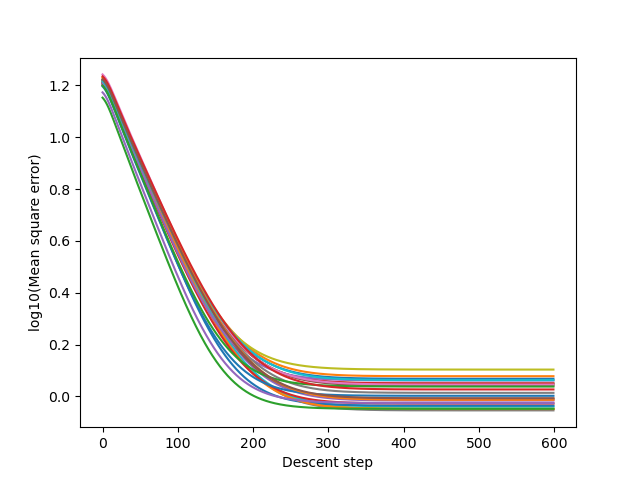

In [21]:
iq0 = ImageQuant2(img=imgs, roi=rois)
iq0.quantify(**kwargs_dict)
res0 = iq0.compile_res()
iq0.plot_losses(log=True)

### Quantification 1

100%|██████████| 600/600 [00:07<00:00, 75.56it/s]


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

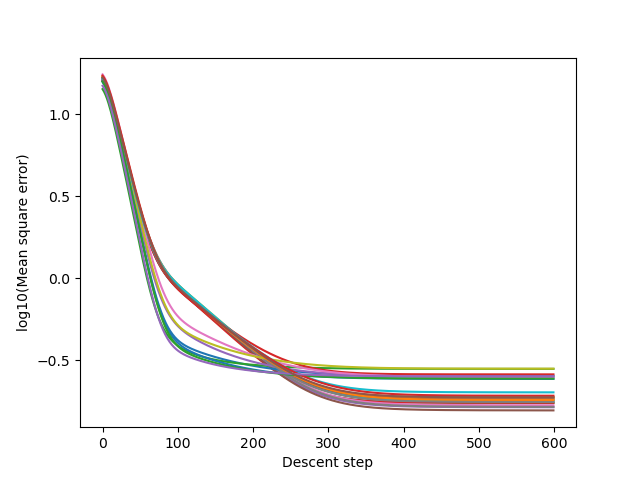

In [22]:
iq1 = ImageQuant2(img=imgs, roi=rois, cytbg=cytbg, membg=membg1)
iq1.quantify(**kwargs_dict)
res1 = iq1.compile_res()
iq1.plot_losses(log=True)

### Quantification 2

100%|██████████| 600/600 [00:08<00:00, 74.56it/s]


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

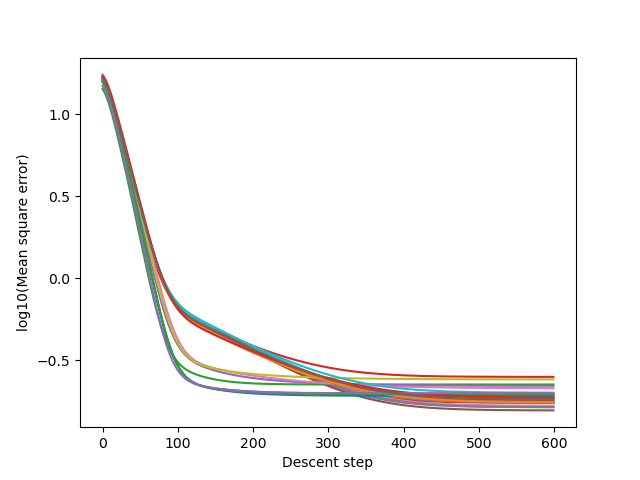

In [23]:
iq2 = ImageQuant2(img=imgs, roi=rois, cytbg=cytbg, membg=membg2)
iq2.quantify(**kwargs_dict)
res2 = iq2.compile_res()
iq2.plot_losses(log=True)

### Quantification 3

100%|██████████| 600/600 [00:07<00:00, 82.01it/s]


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

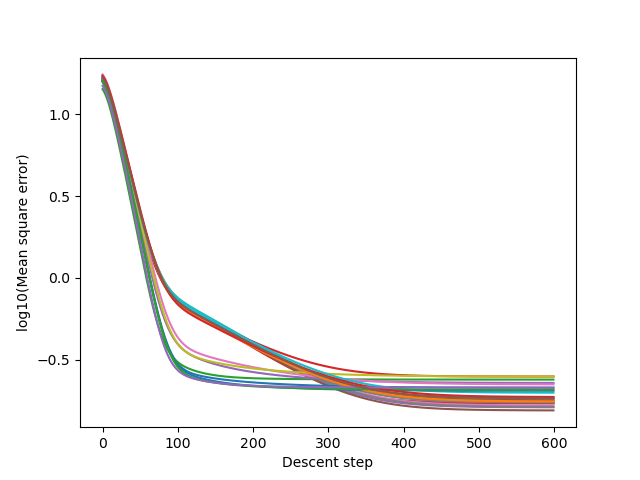

In [24]:
iq3 = ImageQuant2(img=imgs, roi=rois, cytbg=cytbg, membg=membg3)
iq3.quantify(**kwargs_dict)
res3 = iq3.compile_res()
iq3.plot_losses(log=True)

### Quantification 4

100%|██████████| 600/600 [00:08<00:00, 74.51it/s]


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

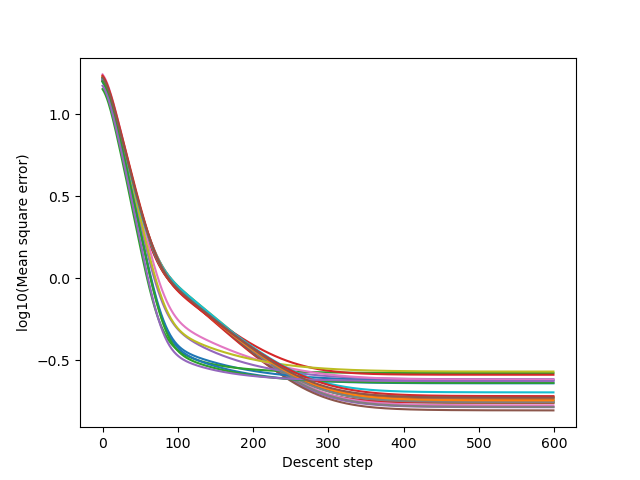

In [25]:
iq4 = ImageQuant2(img=imgs, roi=rois, cytbg=cytbg, membg=membg4)
iq4.quantify(**kwargs_dict)
res4 = iq4.compile_res()
iq4.plot_losses(log=True)

### Quantification 5

100%|██████████| 600/600 [00:07<00:00, 84.60it/s]


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

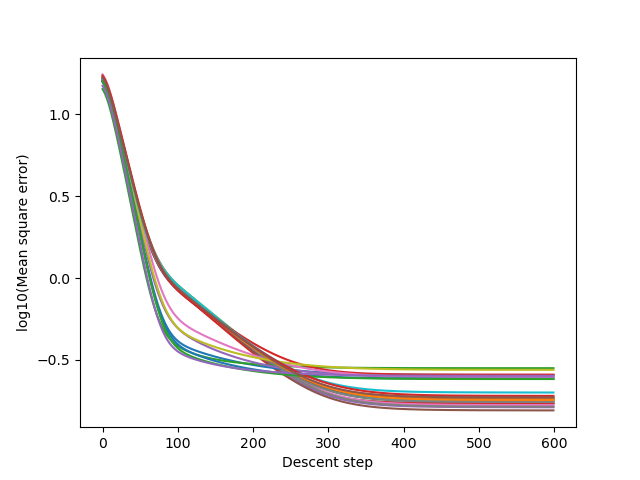

In [26]:
iq5 = ImageQuant2(img=imgs, roi=rois, cytbg=cytbg, membg=membg5)
iq5.quantify(**kwargs_dict)
res5 = iq5.compile_res()
iq5.plot_losses(log=True)

### Quantification 6

100%|██████████| 600/600 [00:09<00:00, 63.25it/s]


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

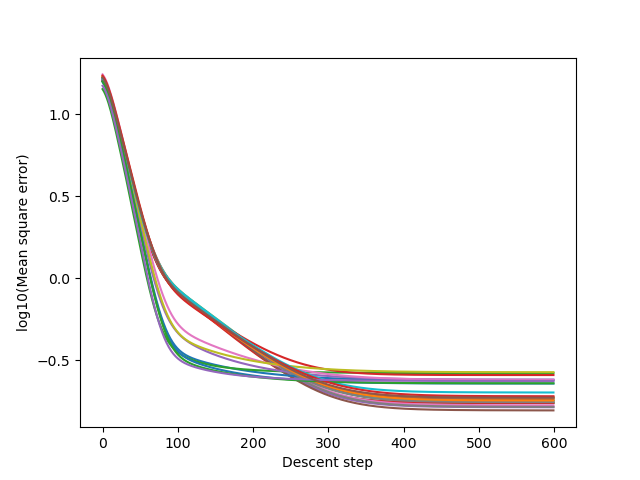

In [27]:
iq6 = ImageQuant2(img=imgs, roi=rois, cytbg=cytbg, membg=membg6)
iq6.quantify(**kwargs_dict)
res6 = iq6.compile_res()
iq6.plot_losses(log=True)

### Get calibrations

In [28]:
def calculate_calibration(res):
    mems = res.groupby('EmbryoID').apply(lambda x: np.mean(x['Membrane signal']))
    cyts = res.groupby('EmbryoID').apply(lambda x: np.mean(x['Cytoplasmic signal']))
    pre_post = [p.split('/')[-1] for p in paths]
    embryos = [p.split('/')[-2] for p in paths]
    lines = [p.split('/')[-3].split('_')[1] for p in paths]

    df_dict = {'Line': lines, 'Embryo': embryos, 'Exposure': pre_post, 'Membrane': mems, 'Cytoplasm': cyts}
    df = pd.DataFrame(df_dict)

    pre = df.groupby(['Line', 'Embryo']).last()
    post = df.groupby(['Line', 'Embryo']).first()
    df = pd.DataFrame({'mem_pre': pre.Membrane, 
                       'mem_post': post.Membrane, 'cyt_pre': pre.Cytoplasm, 
                       'cyt_post': post.Cytoplasm})
    df.to_csv('temp.csv')
    df = pd.read_csv('temp.csv')
    os.remove('temp.csv')
    return df

In [29]:
df0 = calculate_calibration(res0)
df1 = calculate_calibration(res1)
df2 = calculate_calibration(res2)
df3 = calculate_calibration(res3)
df4 = calculate_calibration(res4)
df5 = calculate_calibration(res5)
df6 = calculate_calibration(res6)

In [30]:
def calculate_mean_std(df):
    c = df[df.Line == 'sv2061'].apply(lambda x: ((x.cyt_pre - x.cyt_post) / (x.mem_post - x.mem_pre)) / 0.174, axis=1)
    return np.mean(c), np.std(c)

means, stds = zip(*[calculate_mean_std(df) for df in [df0, df1, df2, df3, df4, df5, df6]])
print(means[-1])
np.savetxt('../../../data/calibration_constants.txt', means)

3.1041166403927325


In [31]:
df6.to_csv('../../../data/calibration_df6.csv')

In [32]:
print(means)

(1.7985472896759958, 3.2903704735082915, 2.440521430506781, 2.9525405952639088, 3.150426367371379, 3.3629798144574097, 3.1041166403927325)
